In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Read in Train and Test Data sets

In [2]:
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
df['unclean'] = df['text']

In [3]:
df.head()

,id,keyword,location,text,target,unclean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


### Check for null values

In [4]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
unclean        0
dtype: int64

In [5]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Key words have %20 instead of spaces so fill those

In [6]:
df['keyword'].unique()[:25]

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard'],
      dtype=object)

**Tweet cleaner**

In [7]:
def cleaner(tweet):
    tweet = tweet.lower()
    tweet = re.sub('[()!?]',"", tweet)
#   tweet = re.sub('\[.*?\]',"", tweet)
    tweet = re.sub("@[A-Za-z0-9_]+","",tweet) #Remove @ sign
#   tweet = re.sub("#[A-Za-z0-9_]+","",tweet) # Remove Hashtags
    tweet = re.sub("http\S+","", tweet) #Remove http links
    tweet = re.sub("www\S+","", tweet) #Remove www links
    tweet = re.sub("[^a-z0-9]"," ", tweet) # Filtering non-alphanumeric characters
    return tweet.lower()

**Fix Training set by filling na values with '' and %20 with ' '.**

In [8]:
df['location'] = df['location'].fillna('')
df['keyword'] = df['keyword'].fillna('')
#df['text'] = df['text'].map(lambda x: cleaner(x))
df = df.replace('%20', ' ', regex=True)

In [9]:
df_test['location'] = df_test['location'].fillna('')
df_test['keyword'] = df_test['keyword'].fillna('')
#df_test['text'] = df_test['text'].map(lambda x: cleaner(x))
df_test = df_test.replace('%20', ' ', regex=True)

In [10]:
df[400:420]

,id,keyword,location,text,target,unclean
400,577,arson,"Los Angeles, CA",Owner of Chicago-Area Gay Bar Admits to Arson ...,0,Owner of Chicago-Area Gay Bar Admits to Arson ...
401,578,arson,"North-East Region, Singapore",@sayn_ae angel or arson,0,@sayn_ae angel or arson
402,579,arson,"Eldoret, kenya",#Kisii Police in Kisii hunt for students over ...,1,#Kisii Police in Kisii hunt for students over ...
403,580,arson,,Mourning notices for stabbing arson victims st...,1,Mourning notices for stabbing arson victims st...
404,581,arson,Chicago,Owner of Chicago-Area Gay Bar Admits to Arson ...,0,Owner of Chicago-Area Gay Bar Admits to Arson ...
405,583,arson,EARTH,Owner of Chicago-Area Gay Bar Admits to Arson ...,0,Owner of Chicago-Area Gay Bar Admits to Arson ...
406,584,arson,"Jerusalem, Israel",Mourning notices for stabbing arson victims st...,1,Mourning notices for stabbing arson victims st...
407,585,arson,,Owner of Chicago-Area Gay Bar Admits to Arson ...,1,Owner of Chicago-Area Gay Bar Admits to Arson ...
408,588,arson,"Menasha, WI",Arson suspect linked to 30 fires caught in Nor...,1,Arson suspect linked to 30 fires caught in Nor...
409,589,arson,,Tennessee lesbian couple faked hate crime and ...,1,Tennessee lesbian couple faked hate crime and ...


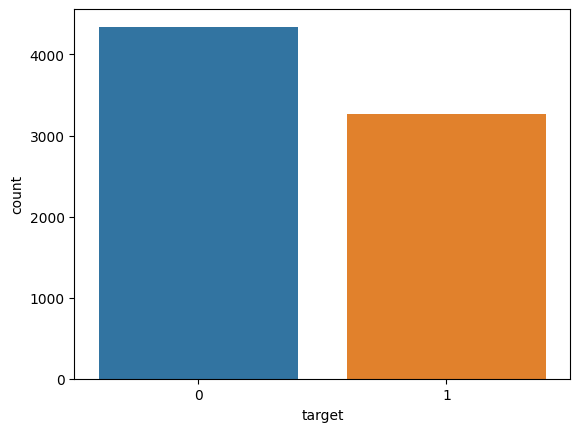

In [11]:
sns.countplot(data=df, x='target');

In [12]:
df[800:1400]

,id,keyword,location,text,target,unclean
800,1160,blight,Laventillemoorings,If you dotish to blight your car go right ahea...,0,If you dotish to blight your car go right ahea...
801,1162,blight,UK,Sexual Revolution:Blight For Women is out! htt...,0,Sexual Revolution:Blight For Women is out! htt...
802,1164,blight,Scotland,LIKE I SWEAR THE SECRET WE'LL UNCOVER IS THE O...,0,LIKE I SWEAR THE SECRET WE'LL UNCOVER IS THE O...
803,1166,blight,London,@WillHillBet what is double result live on the...,0,@WillHillBet what is double result live on the...
804,1167,blight,"Vancouver, BC",@parksboardfacts first off it is the #ZippoLin...,0,@parksboardfacts first off it is the #ZippoLin...
...,...,...,...,...,...,...
1395,2014,casualties,Philippines,Civilian casualties rise as Afghan war intensi...,1,Civilian casualties rise as Afghan war intensi...
1396,2015,casualties,,Afghan conflict sees 'sharp rise' in female ca...,1,Afghan conflict sees 'sharp rise' in female ca...
1397,2016,casualties,"Bronx, New York",Warfighting Robots Could Reduce Civilian Casua...,1,Warfighting Robots Could Reduce Civilian Casua...
1398,2017,casualties,Canadian bread,@LibertarianLuke I'm all for that to be honest...,0,@LibertarianLuke I'm all for that to be honest...


## Plot to show some of the positive/negative ratios for given keywords
Some of the keywords are pretty strongly correlated

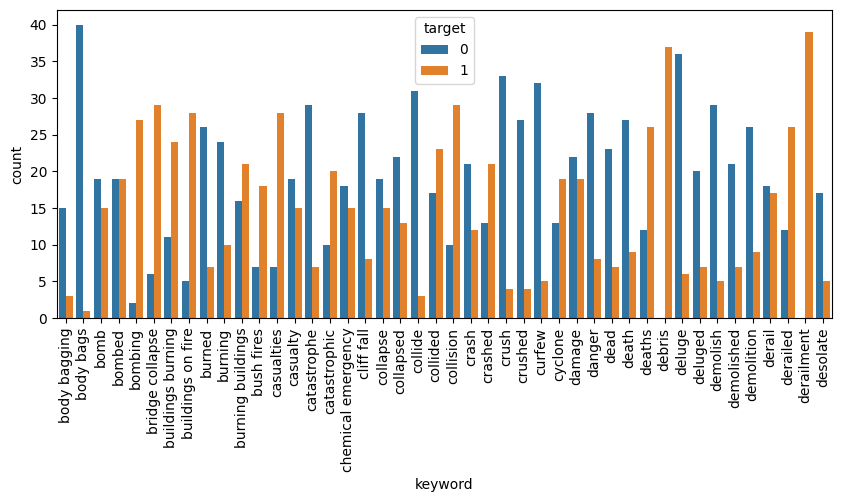

In [13]:
plt.figure(figsize=(10,4))
sns.countplot(data=df[1000:2500], x='keyword',hue='target')
plt.xticks(rotation=90);

# Split Train Data to do inital testing

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df['text combo'] = df['keyword']+" "+df['location']+" "+df['text']
df_test['text combo'] = df_test['keyword']+" "+df_test['location']+" "+df_test['text']

df[800:804]

,id,keyword,location,text,target,unclean,text combo
800,1160,blight,Laventillemoorings,If you dotish to blight your car go right ahea...,0,If you dotish to blight your car go right ahea...,blight Laventillemoorings If you dotish to bl...
801,1162,blight,UK,Sexual Revolution:Blight For Women is out! htt...,0,Sexual Revolution:Blight For Women is out! htt...,blight UK Sexual Revolution:Blight For Women i...
802,1164,blight,Scotland,LIKE I SWEAR THE SECRET WE'LL UNCOVER IS THE O...,0,LIKE I SWEAR THE SECRET WE'LL UNCOVER IS THE O...,blight Scotland LIKE I SWEAR THE SECRET WE'LL ...
803,1166,blight,London,@WillHillBet what is double result live on the...,0,@WillHillBet what is double result live on the...,blight London @WillHillBet what is double resu...


In [16]:
#X = df.drop(['target','id'], axis=1)
X = df.drop('target',axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=814)
ids_train = X_train['id']
X_train = X_train['text combo']
ids_test = X_test['id']
X_test = X_test['text combo']

In [17]:
df_test

,id,keyword,location,text,text combo
0,0,,,Just happened a terrible car crash,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities,..."
2,3,,,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese a..."
3,9,,,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...,...
3258,10861,,,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FAS...
3259,10865,,,Storm in RI worse than last hurricane. My city...,Storm in RI worse than last hurricane. My ci...
3260,10868,,,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago http://t.co...
3261,10874,,,MEG issues Hazardous Weather Outlook (HWO) htt...,MEG issues Hazardous Weather Outlook (HWO) h...


# Setup various models to test

In [18]:
#from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report,f1_score,confusion_matrix,ConfusionMatrixDisplay

### Vectorize the text data

In [19]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [20]:
X_train_tfidf

<6090x19857 sparse matrix of type '<class 'numpy.float64'>'
	with 67292 stored elements in Compressed Sparse Row format>

###  MultinomialNB model

In [21]:
mnb = MultinomialNB()
param_grid = {'alpha':[1,2,5,10]}
mnb_grid = GridSearchCV(estimator=mnb, param_grid=param_grid, scoring='f1')
mnb_start = time.time()
mnb_grid.fit(X_train_tfidf, y_train)
mnb_end = time.time()
print(f'Time to fit = {mnb_end - mnb_start:.3f}s')
mnb_grid.best_params_

Time to fit = 0.203s


{'alpha': 1}

0.731958762886598
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       868
           1       0.84      0.65      0.73       655

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523



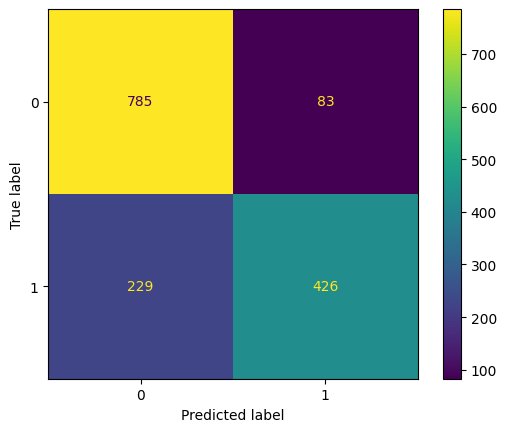

In [22]:
mnb_preds = mnb_grid.predict(X_test_tfidf)
print(f1_score(y_test,mnb_preds))
print(classification_report(y_test,mnb_preds))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, mnb_preds)).plot();

###  LogisticRegression model

In [23]:
log = LogisticRegression(max_iter=1000)
param_grid = {'C':[3,4,5,6,7,8]}
log_grid = GridSearchCV(estimator=log, param_grid=param_grid, scoring='f1')
log_start = time.time()
log_grid.fit(X_train_tfidf, y_train)
log_end = time.time()
print(f'Time to fit = {log_end - log_start:.3f}s')
log_grid.best_params_

Time to fit = 22.409s


{'C': 4}

0.7470071827613728
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       868
           1       0.78      0.71      0.75       655

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523



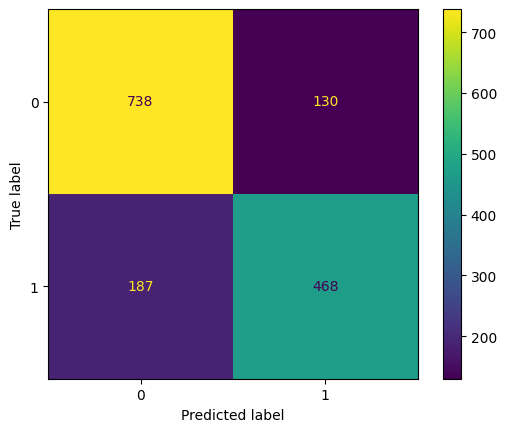

In [24]:
log_preds = log_grid.predict(X_test_tfidf)
print(f1_score(y_test,log_preds))
print(classification_report(y_test,log_preds))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, log_preds)).plot();

### SGDClassifier model

In [25]:
sgdc = SGDClassifier()
#param_grid = {'C':[3,4,5,6,7,8]}
#log_grid = GridSearchCV(estimator=log, param_grid=param_grid, scoring='f1')
sgdc_start = time.time()
sgdc.fit(X_train_tfidf, y_train)
sgdc_end = time.time()
print(f'Time to fit = {sgdc_end - sgdc_start:.3f}s')
sgdc.coef_

Time to fit = 0.049s


array([[-0.32796702, -0.48454173,  0.40476673, ...,  0.38797534,
        -0.18033906,  0.21186879]])

0.7508038585209004
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       868
           1       0.79      0.71      0.75       655

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.79      1523



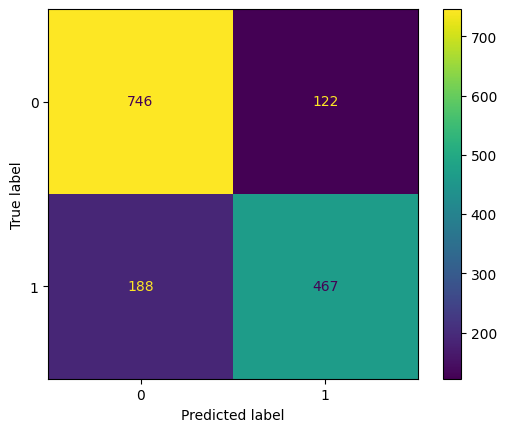

In [26]:
sgdc_preds = sgdc.predict(X_test_tfidf)
print(f1_score(y_test,sgdc_preds))
print(classification_report(y_test,sgdc_preds))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, sgdc_preds)).plot();

### LinearSVC model

In [27]:
lin_svc = LinearSVC()
param_grid = {'C':[1,2,5,10]}
lin_svc_grid = GridSearchCV(estimator=lin_svc, param_grid=param_grid, scoring='f1')
lin_svc_start = time.time()
lin_svc_grid.fit(X_train_tfidf, y_train)
lin_svc_end = time.time()
print(f'Time to fit = {lin_svc_end - lin_svc_start:.3f}s')
lin_svc_grid.best_params_

Time to fit = 1.653s


{'C': 1}

0.7432646592709985
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       868
           1       0.77      0.72      0.74       655

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



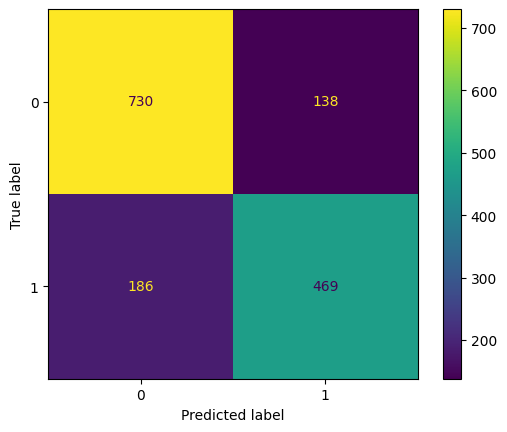

In [28]:
lin_svc_preds = lin_svc_grid.predict(X_test_tfidf)
print(f1_score(y_test,lin_svc_preds))
print(classification_report(y_test,lin_svc_preds))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, lin_svc_preds)).plot();

### SVC model
<span style="font-size:16px;color:red;"> Below cell is the slowest cell by far (takes ~4 minutes with the grid search) </span>

In [29]:
# svc = SVC()
# param_grid = {'C': [1,10,100], 
#               'gamma': [1,0.1,0.01]}
# svc_grid = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1')
# svc_start = time.time()
# svc_grid.fit(X_train_tfidf, y_train)
# svc_end = time.time()
# print(f'Time to fit = {svc_end - svc_start:.3f}s')
# svc_grid.best_params_

In [30]:
# svc_preds = svc_grid.predict(X_test_tfidf)
# print(f1_score(y_test,svc_preds))
# print(classification_report(y_test,svc_preds))
# ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, svc_preds)).plot();

# Compare Models

In [31]:
print(f'MNB time to fit = {mnb_end - mnb_start:.3f}s')
print(f'MNB f1 score = {f1_score(y_test,mnb_preds):.4f}')
print('-'*10)
print(f'LogReg time to fit = {log_end - log_start:.3f}s')
print(f'LogReg f1 score = {f1_score(y_test,log_preds):.4f}')
print('-'*10)
print(f'SGDClass time to fit = {sgdc_end - sgdc_start:.3f}s')
print(f'SGDClass f1 score = {f1_score(y_test,sgdc_preds):.4f}')
print('-'*10)
print(f'LinSVC time to fit = {lin_svc_end - lin_svc_start:.3f}s')
print(f'LinSVC f1 score = {f1_score(y_test,lin_svc_preds):.4f}')
# print('-'*10)
# print(f'SVC time to fit = {svc_end - svc_start:.3f}s')
# print(f'SVC f1 score = {f1_score(y_test,svc_preds):.4f}')

MNB time to fit = 0.203s
MNB f1 score = 0.7320
----------
LogReg time to fit = 22.409s
LogReg f1 score = 0.7470
----------
SGDClass time to fit = 0.049s
SGDClass f1 score = 0.7508
----------
LinSVC time to fit = 1.653s
LinSVC f1 score = 0.7433


# Final Data Set prep

In [32]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X['text combo'])
X_final_train_tfidf = tfidf.transform(X['text combo'])
X_final_test_tfidf = tfidf.transform(df_test['text combo'])
ids_out = df_test['id']

## Final dataset

In [33]:
X_final_train_tfidf

<7613x23181 sparse matrix of type '<class 'numpy.float64'>'
	with 84162 stored elements in Compressed Sparse Row format>

In [34]:
# model = SVC(**svc_grid.best_params_)
model = LogisticRegression(max_iter=1000, **log_grid.best_params_)
# model = SGDClassifier()
final_start = time.time()
model.fit(X_final_train_tfidf, y)
final_end = time.time()
print(f'Time to fit = {final_end - final_start:.3f}s')

Time to fit = 1.076s


In [35]:
final_preds = model.predict(X_final_test_tfidf)

# Final output formatting

In [36]:
output_df = pd.DataFrame({'id': ids_out,
                          'target': final_preds.squeeze()})

In [37]:
output_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [38]:
output_df.to_csv('/kaggle/working/submission.csv', index=False)